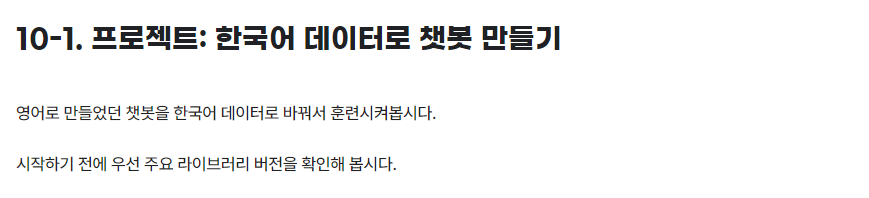

In [1]:
#라이브러리 불러오기
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

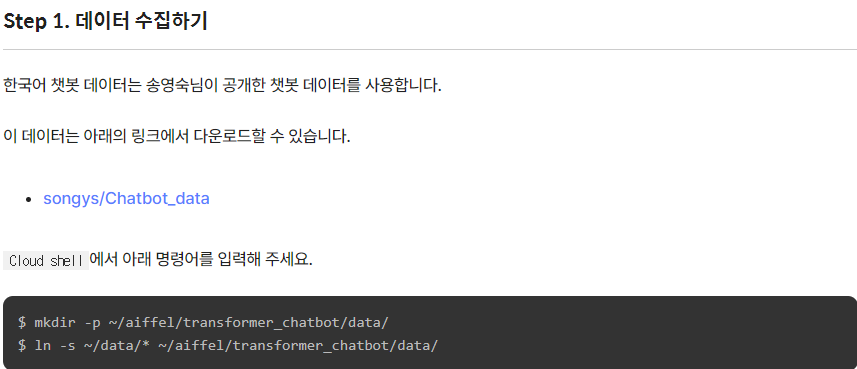
https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

In [3]:
# !mkdir -p ~/aiffel/transformer_chatbot/data/
# !ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

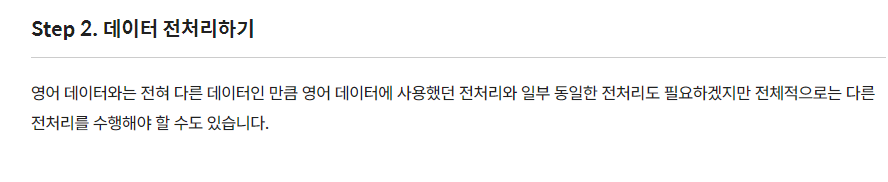

In [4]:
import pandas as pd

dataset_filepath = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(dataset_filepath)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [6]:
#데이터 개수확인
len(data)

11823

In [7]:
# 사용할 샘플의 최대 개수(데이터셋의 총 개수만큼 크기를 정해준다.)
MAX_SAMPLES = 11823
print(MAX_SAMPLES)

11823


In [8]:
# 전처리 함수(데이터를 확인후 필요없는 특수문자 제거및 공백제거)
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()

    return sentence



In [9]:
#데이터셋이 questions, answers로 나눠져있으니 input과 output을 각각 questions, answers로 지정
#데이터셋이 txt형식이아니라 이미 csv파일 형식이기때문에 딕셔너리형태가아니라 리스트만 만들어 각각 questions, answers를 반복문을 통해 리스트에 추가
def load_conversations(questions, answers):
    inputs, outputs = [], []
    
    for question, answer in zip(questions, answers):
        inputs.append(preprocess_sentence(question))
        outputs.append(preprocess_sentence(answer))
        
    return inputs, outputs

In [12]:
questions, answers = load_conversations(data['Q'], data['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [13]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


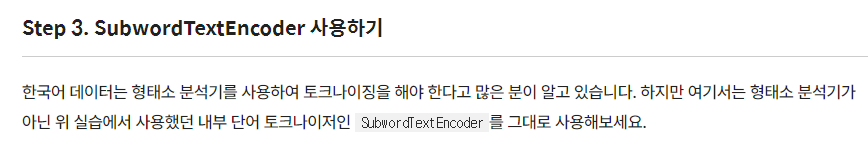

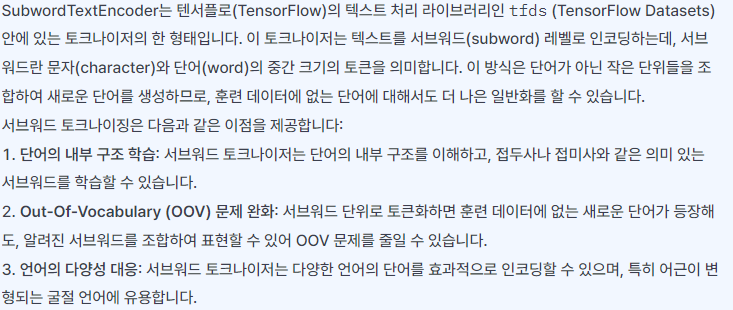

In [14]:
#SubwordTextEncoder사용하여 단어장만들기(각 단어에 고유한 정수 인덱스 부여)
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("ok ")

ok 


In [15]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.(디코더의 문장 생성 과정에서 사용할 시작과 끝을 알려주는 토큰추가)
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("ok")

ok


In [16]:
print('START_TOKEN의 번호 :', [tokenizer.vocab_size])
print('END_TOKEN의 번호 :', [tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [17]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [18]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5763, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [19]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [21]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("ok")

ok


In [22]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
#처음 데이터셋의 샘플개수와 달라진것이없다(데이터셋의 길이가40을 넘지않는다.)

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [34]:
#교사강요 사용하기
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("ok")

ok


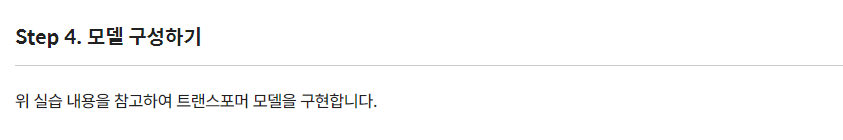

In [24]:
# 포지셔널 인코딩 레이어(각각 단어의 순서정보, 즉 시퀀스의 상태를 보존하기위해사용)
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("ok")

ok


In [25]:
# 스케일드 닷 프로덕트 어텐션 함수(단어의 유사도를 어텐션 메커니즘을 사용해 값을 얻음)
#특정 분모를 사용하여 스케일링한다.(스케일링을 하지않으면 백터의 내적시 차원의 수가 매우 커지기때문에 출력값이 작아져 역전파시 기울기 소실문제가 발생할 수 있기때문)
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("ok")

ok


In [27]:
#단어의 각각 다른 관점에서 어텐션을 수행하여 병렬적으로 처리하여 좀더 정확한 유사도를 찾기위해 MultiHeadAttention을사용
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query =self.query_dense(query)
    key = self.key_dense(key)
    value =self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("ok")

ok


In [28]:
#패딩마스킹(벡터로 변환한 값들의 내적시 길이가 다르다면 내적이 불가능하기때문에 padding을 사용하여 길이를 맞추어준다.)
#padding을 사용하면 어텐션시 유사도를 구할때 방해가 될수있음으로 masking을 통해 필요없는(padding을 추가한값)을 가려준다.
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("ok")

ok


In [29]:
#룩 어헤드 마스킹(트랜스포머가 자기 회귀모델이기때문에 디코더에서 생성시 다음단어를 참조하지않기위해 )
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("ok")

ok


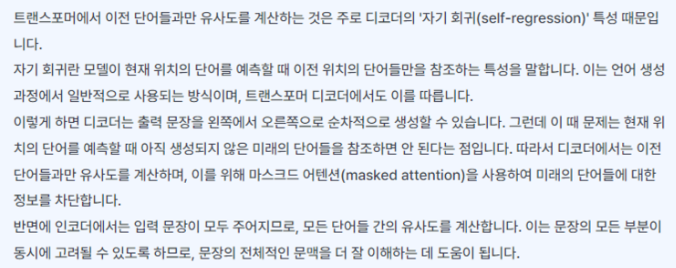

In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("ok")

ok


In [31]:
#인코더 층을 인코더 만들기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("ok")

ok


In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("ok")

ok


In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("ok")

ok


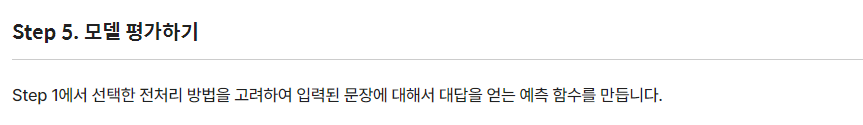

In [35]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("ok")

ok


In [36]:
tf.keras.backend.clear_session()#이전모델들과 분리(새로운 모델 정의)

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수(논문과같은 크기)
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원(논문과 같은 크기)
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13653504    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

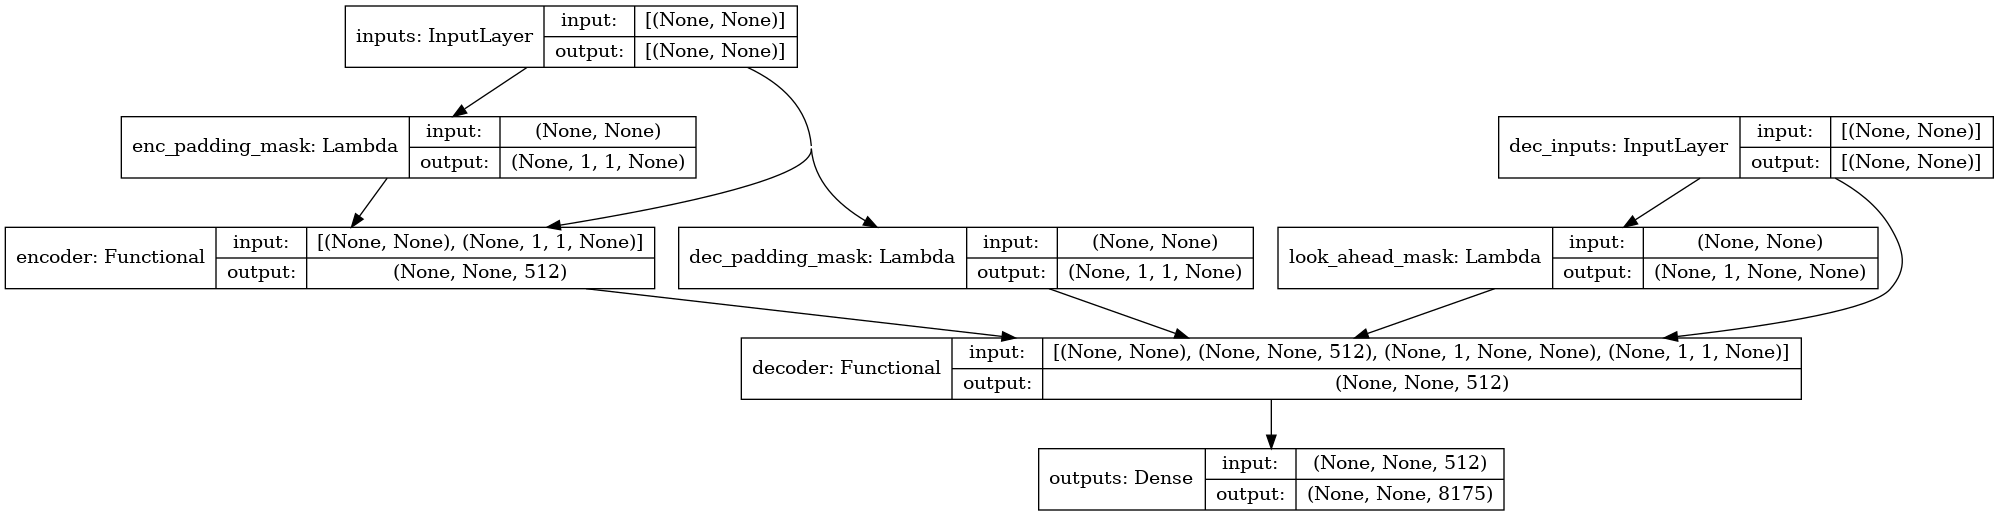

In [40]:
#모델구조 시각화
from tensorflow.keras import  utils
utils.plot_model(model,show_shapes=True)

In [38]:
#손실함수 구현
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("ok")

ok


In [56]:
#커스텀 학습률(학습률 스케쥴링)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
#학습률 스케줄러 객체를 저장하고 필요할때 불러오기위한 get_config함수구현
  def get_config(self):
    return {
        "d_model": self.d_model.numpy(),
        "warmup_steps": self.warmup_steps
    }
print("ok")

ok


Text(0.5, 0, 'Train Step')

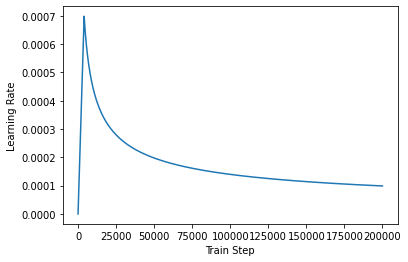

In [57]:
#학습률이 어떻게 편할지시각화
sample_learning_rate = CustomSchedule(d_model=512)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [48]:
#!mkdir -p ~/aiffel/transformer_chatbot/training_checkpoints/

In [62]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 체크포인트를 저장할 경로 설정
checkpoint_dir = os.getenv('HOME')+'/aiffel/transformer_chatbot/training_checkpoints'

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 생성
# ModelCheckpoint 콜백 생성
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # 옵티마이저와 가중치 모두 저장
    save_best_only=True,     # 최적의 학습된 모델의 값만 가져옴
    verbose=1)                # 체크포인트 저장 시 로그 출력

print("ok")

ok


In [69]:
#모델의 성능향상을위해 학습시 콜백을 사용하여 옵티마이저와 가중치의 학습을 이어서 진행해봄 
EPOCHS = 20
history=model.fit(dataset, epochs=EPOCHS,callbacks=[model_checkpoint_callback], verbose=1)

Epoch 1/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0193 - accuracy: 0.1699


Epoch 2/20
185/185 [==============================] - 41s 220ms/step - loss: 0.0178 - accuracy: 0.1704


Epoch 3/20
185/185 [==============================] - 40s 219ms/step - loss: 0.0173 - accuracy: 0.1705


Epoch 4/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0171 - accuracy: 0.1705


Epoch 5/20
185/185 [==============================] - 41s 220ms/step - loss: 0.0158 - accuracy: 0.1709


Epoch 6/20
185/185 [==============================] - 40s 219ms/step - loss: 0.0155 - accuracy: 0.1709


Epoch 7/20
185/185 [==============================] - 41s 220ms/step - loss: 0.0147 - accuracy: 0.1711


Epoch 8/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0144 - accuracy: 0.1713


Epoch 9/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0136 - accuracy: 0.1716


Epoch 10/20
185/185 [==============================] - 41s 220ms/step - loss: 0.0135 - accuracy: 0.1716


Epoch 11/20
185/185 [==============================] - 41s 220ms/step - loss: 0.0133 - accuracy: 0.1716


Epoch 12/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0127 - accuracy: 0.1718


Epoch 13/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0123 - accuracy: 0.1718


Epoch 14/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0120 - accuracy: 0.1720


Epoch 15/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0114 - accuracy: 0.1720


Epoch 16/20
185/185 [==============================] - 40s 219ms/step - loss: 0.0109 - accuracy: 0.1722


Epoch 17/20
185/185 [==============================] - 41s 220ms/step - loss: 0.0115 - accuracy: 0.1720


Epoch 18/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0110 - accuracy: 0.1723


Epoch 19/20
185/185 [==============================] - 40s 219ms/step - loss: 0.0102 - accuracy: 0.1724


Epoch 20/20
185/185 [==============================] - 41s 219ms/step - loss: 0.0098 - accuracy: 0.1726


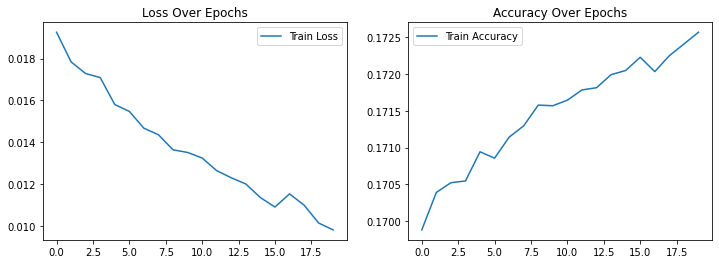

In [70]:
plt.figure(figsize=(12,4))

# 훈련 및 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')

plt.title('Loss Over Epochs')
plt.legend()

# 훈련 및 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')

plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

In [66]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("ok")

ok


In [67]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("ok")

ok


### 처음 에폭10만 돌렸을때
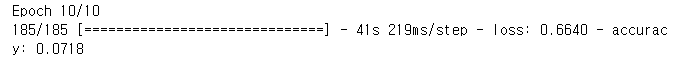

In [54]:
sentence_generation("오늘 날씨 어때?")

입력 : 오늘 날씨 어때?
출력 : 직접 물어보세요 .


'직접 물어보세요 .'

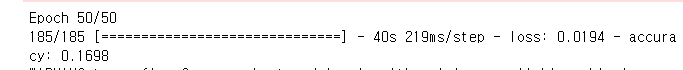

In [68]:
sentence_generation("오늘 날씨 어때?")

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

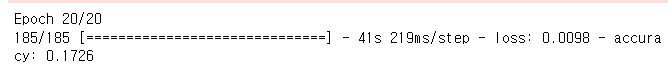

In [71]:
sentence_generation("오늘 날씨 어때?")

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [72]:
sentence_generation("공부하는게 힘드네")

입력 : 공부하는게 힘드네
출력 : 공부하면 더 많은 선택을 할 수 있죠 .


'공부하면 더 많은 선택을 할 수 있죠 .'

In [73]:
sentence_generation("인공지능은 뭘까?")

입력 : 인공지능은 뭘까?
출력 : 만나고 싶으면 만나야죠 .


'만나고 싶으면 만나야죠 .'

In [81]:
sentence_generation("배고파")
sentence_generation("같이 밥먹으러 갈래?")
sentence_generation("같이 밥먹으러 가자")
sentence_generation("알았어.. 혼자밥먹으러갈게")
sentence_generation("강아지 키우고 싶어")

입력 : 배고파
출력 : 얼른 맛난 음식 드세요 .
입력 : 같이 밥먹으러 갈래?
출력 : 맛있게 드세요 .
입력 : 같이 밥먹으러 가자
출력 : 맛있게 드세요 .
입력 : 알았어.. 혼자밥먹으러갈게
출력 : 조심하세요 .
입력 : 강아지 키우고 싶어
출력 : 책임질 수 있을 때 키워 보세요 .


'책임질 수 있을 때 키워 보세요 .'

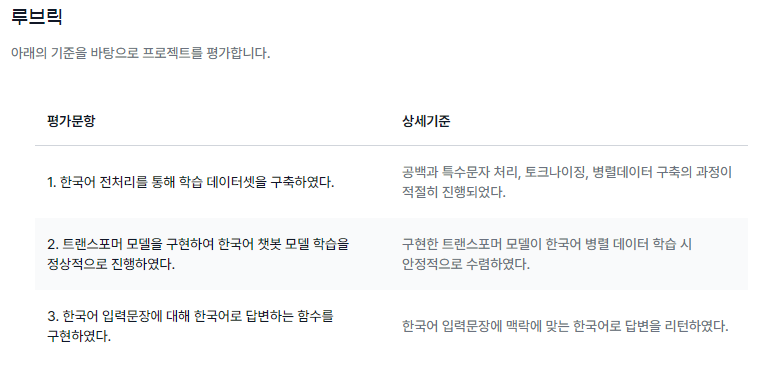

### 추후 성능을 향상시키는 방법
- 데이터 개수 늘리기 번역하여 다국어언어로만든후 역번역시킨다
- 앙상블기법 활용,하이퍼파라미터값 조정
- 다양한 모델 시도해보기
- 토크나이징 전처리 잘 하기
- 전이학습모델 사용

## 회고
- k:처음다루는 내용이다보니 어려운부분도 많았고 모델의 구조나 학습방법등, 이해하기 어려운부분이 엄청많았지만 반복해서 읽어보고 다른 자료도 찾아보면서 최대한 이해하려고 노력하였더니 어느정도 흐름을 이해하고 왜 이렇게 구조가되고 알고리즘을 사용하는지 알게되었던거같다.
- p:새로운 내용이 많다보니 코드작성하는것도 쉽지않았고 쉽게 변형시키기가 어려웠다.데이터가 적다보니 학습한 부분에서는 좋은 답변을 얻었지만 그렇지못한 부분에서는 엉뚱한 대답이나온것으로 보아 데이터가 많이 필요하다는것을 느꼈다.
- t:다른 데이터를 추가로 구하거나 pre=trained모델을 활용해보거나 성능을 높일수있는 방법을 많이 시도해보아야겠다.